# Customer Segmentation with K-Means

In [30]:
import pandas as pd
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import numpy as np
import warnings

In [31]:
pd.set_option ('display.max_columns', 50)
pd.set_option ('display.max_rows', 50)
pd.set_option ('display.float_format', lambda x: '%.2f' % x)
pd.set_option ('display.width', 1000)
warnings.filterwarnings ("ignore")

In [32]:
df_ = pd.read_excel ("online_retail_II-230817-120704.xlsx", sheet_name="Year 2009-2010")

df = df_.copy ()

In [33]:
def check_df(dataframe, head = 5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.head(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.95, 0.99, 1]).T)

In [34]:
check_df(df)

##################### Shape #####################
(525461, 8)
##################### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
##################### Head #####################
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12 2009-12-01 07:45:00   6.95     13085.00  United Kingdom
1  489434    79323P                   PINK CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75     13085.00  United Kingdom
2  489434    79323W                  WHITE CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75     13085.00  United Kingdom
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48 2009-12-01 07:45:00   2.10

In [35]:
def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds (dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any (axis=None):
        return True
    else:
        return False

In [36]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile (q1)
    quartile3 = dataframe[col_name].quantile (q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [37]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds (dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [38]:
df = df[~df["Invoice"].str.contains("C", na = False)]

In [39]:
df = df[(df["Quantity"] > 0)]

In [40]:
df.dropna(inplace= True)

In [41]:
df.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
Quantity,407695.00,13.59,96.84,1.00,1.00,1.00,2.00,5.00,12.00,24.00,144.00,19152.00
Price,407695.00,3.29,34.76,0.00,0.29,0.65,1.25,1.95,3.75,6.75,14.95,10953.50
Customer ID,407695.00,15368.50,1679.80,12346.00,12435.00,13044.00,13997.00,15321.00,16812.00,17706.00,18196.00,18287.00


In [42]:
df[df["Price"] == 0]["StockCode"].unique()

array([22076, 48185, 'M', 22065, 22142, 85042, 21143, 79320, 22355, 21533,
       'TEST001', 21662, 22459, 22458, 22376, 21765, 20914, 22423, 22690,
       22472, 22202, '46000M', 22218, 22630, 22121, 21843, 22624, 22846,
       22845, 22841], dtype=object)

In [43]:
df = df[df["StockCode"] != "M"]

In [44]:
invalid_codes = df[df["StockCode"].astype(str).str.contains(r"[a-zA-Z]{3,}")]["StockCode"].unique().tolist()

In [45]:
invalid_codes

['POST', 'BANK CHARGES', 'TEST001', 'TEST002', 'PADS', 'ADJUST', 'ADJUST2']

In [46]:
df[df["StockCode"].isin (invalid_codes)].groupby(["StockCode"]).agg({"Invoice": "nunique",
                                                                    "Quantity" : "sum",
                                                                    "Price" : "sum",
                                                                     "Customer ID" : "nunique"})

,Invoice,Quantity,Price,Customer ID
StockCode,,,,
ADJUST,32,32,3538.52,25
ADJUST2,3,3,731.05,3
BANK CHARGES,20,20,300.00,12
PADS,14,14,0.01,12
POST,738,2212,19964.83,230
TEST001,11,60,40.50,4
TEST002,1,1,1.00,1


In [47]:
df = df[~df["StockCode"].isin(invalid_codes)].reset_index(drop = True)

In [49]:
check_df(df)

##################### Shape #####################
(406450, 8)
##################### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
##################### Head #####################
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12 2009-12-01 07:45:00   6.95     13085.00  United Kingdom
1  489434    79323P                   PINK CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75     13085.00  United Kingdom
2  489434    79323W                  WHITE CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75     13085.00  United Kingdom
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48 2009-12-01 07:45:00   2.10

In [50]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [51]:
df.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
Quantity,406450.00,13.62,96.99,1.00,1.00,1.00,2.00,5.00,12.00,24.00,144.00,19152.00
Price,406450.00,3.01,4.37,0.00,0.29,0.65,1.25,1.95,3.75,6.75,12.75,295.00
Customer ID,406450.00,15373.48,1677.23,12346.00,12437.00,13050.00,14006.00,15325.00,16814.00,17706.00,18196.00,18287.00
TotalPrice,406450.00,21.36,69.14,0.00,0.65,2.10,4.95,11.85,19.50,35.40,197.10,15818.40


In [52]:
max_invoice_date = df["InvoiceDate"].max()

In [53]:
max_invoice_date

Timestamp('2010-12-09 20:01:00')

In [57]:
today_date = (max_invoice_date + dt.timedelta (days=2))

In [58]:
today_date

Timestamp('2010-12-11 20:01:00')

In [60]:
rfm = df.groupby("Customer ID").agg({"InvoiceDate" : lambda date : (today_date - date.max()).days,
                                    "Invoice" : "nunique",
                                    "TotalPrice" : "sum"})

In [61]:
rfm.head()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.00,166,2,169.36
12347.00,4,2,1323.32
12348.00,75,1,221.16
12349.00,44,2,2221.14
12351.00,12,1,300.93


In [62]:
rfm.columns = ["Recency", "Frequency", "Monetary"]

In [63]:
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.00,166,2,169.36
12347.00,4,2,1323.32
12348.00,75,1,221.16
12349.00,44,2,2221.14
12351.00,12,1,300.93


In [69]:
rfm = rfm[(rfm["Monetary"]) > 0 & (rfm["Frequency"] > 0)]

In [70]:
rfm.describe ([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
Recency,4286.00,91.56,96.35,2.00,2.00,9.00,19.00,53.00,136.75,255.00,369.00,375.00
Frequency,4286.00,4.11,4.89,1.00,1.00,1.00,1.00,2.00,5.00,9.00,31.00,31.00
Monetary,4286.00,1588.58,2523.16,1.55,40.76,157.03,307.66,702.25,1703.98,3761.56,15243.20,15243.20


In [71]:
for col in rfm.columns:
    print( col, check_outlier(rfm, col))

Recency False
Frequency False
Monetary False


In [72]:
replace_with_thresholds(rfm, "Frequency")

In [73]:
replace_with_thresholds(rfm, "Monetary")

In [74]:
for col in rfm.columns:
    print( col, check_outlier(rfm, col))

Recency False
Frequency False
Monetary False


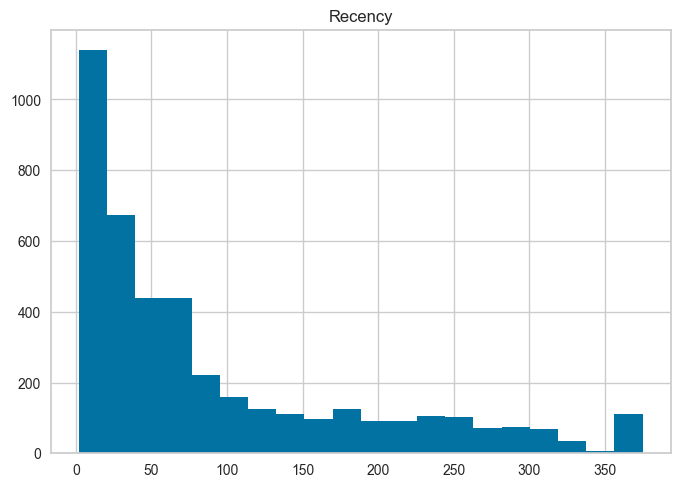

In [75]:
rfm["Recency"].hist(bins = 20)
plt.title ("Recency")
plt.show ()

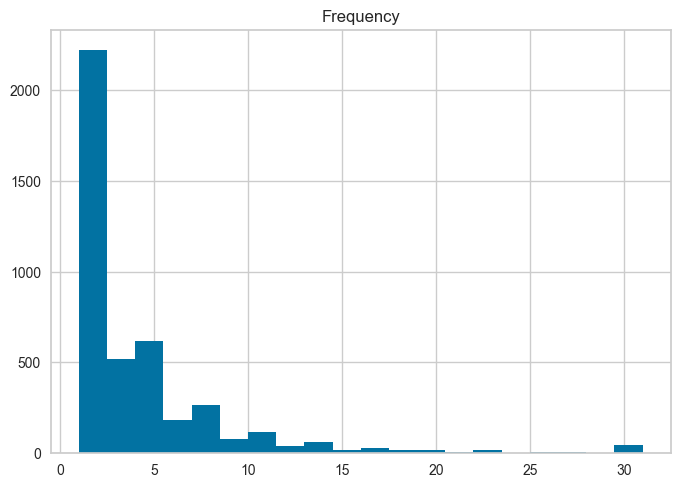

In [77]:
rfm["Frequency"].hist(bins = 20)
plt.title ("Frequency")
plt.show ()

In [78]:
# LOG TRANSFORMATION
for col in ["Recency", "Frequency"]:
    rfm[f"LOG_{col}"] = np.log1p (rfm[col])

In [80]:
rfm.head()

,Recency,Frequency,Monetary,LOG_Recency,LOG_Frequency
Customer ID,,,,,
12346.00,166,2,169.36,5.12,1.10
12347.00,4,2,1323.32,1.61,1.10
12348.00,75,1,221.16,4.33,0.69
12349.00,44,2,2221.14,3.81,1.10
12351.00,12,1,300.93,2.56,0.69


In [82]:
# SCALER
sc = StandardScaler()
sc.fit(rfm[["LOG_Recency", "LOG_Frequency"]])
scaled_rf = sc.transform(rfm[["LOG_Recency", "LOG_Frequency"]])

In [83]:
scaled_df = pd.DataFrame (index = rfm.index, columns = ["LOG_Recency", "LOG_Frequency"], data = scaled_rf)

In [84]:
scaled_df

,LOG_Recency,LOG_Frequency
Customer ID,,
12346.00,0.99,-0.40
12347.00,-1.85,-0.40
12348.00,0.35,-1.00
12349.00,-0.07,-0.40
12351.00,-1.08,-1.00
...,...,...
18283.00,-0.73,0.87
18284.00,0.27,-1.00
18285.00,1.45,-1.00


In [85]:
# Determining Optimal Numbers of Cluster

In [86]:
kmeans = KMeans()

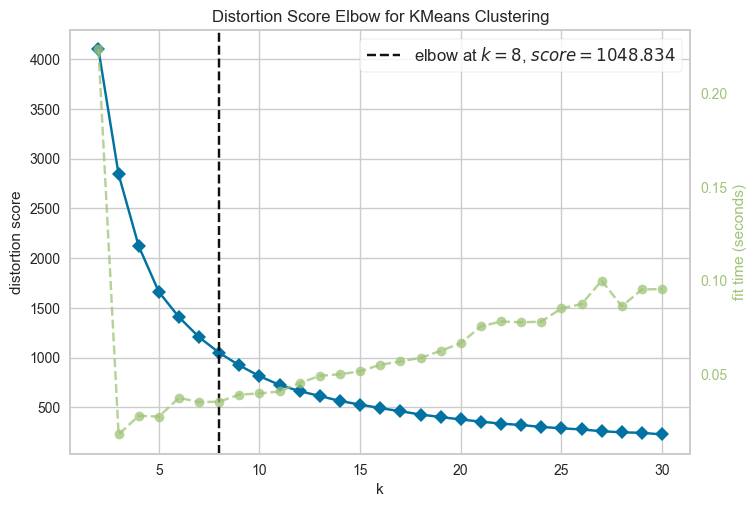

In [88]:
elbow = KElbowVisualizer(kmeans, k = 30)
elbow.fit(scaled_df)
elbow.show();

In [89]:
k_ = elbow.elbow_value_

In [90]:
k_

8

In [91]:
# K-Means

In [92]:
k_means = KMeans (n_clusters= k_, random_state= 99).fit(scaled_df)

In [93]:
segments = k_means.labels_

In [94]:
rfm["KMeans_Segments"] = segments

In [95]:
rfm.head()

,Recency,Frequency,Monetary,LOG_Recency,LOG_Frequency,KMeans_Segments
Customer ID,,,,,,
12346.00,166,2,169.36,5.12,1.10,5
12347.00,4,2,1323.32,1.61,1.10,7
12348.00,75,1,221.16,4.33,0.69,0
12349.00,44,2,2221.14,3.81,1.10,0
12351.00,12,1,300.93,2.56,0.69,4


In [97]:
rfm.groupby("KMeans_Segments").agg({"Recency" : ["mean", "median", "count"],
                                   "Frequency" : ["mean", "median", "count"],
                                   "Monetary": ["mean", "median", "count"]})

Recency              Frequency              Monetary              
                   mean median count      mean median count     mean  median count
KMeans_Segments                                                                   
0                 69.79  66.00   797      1.44   1.00   797   535.69  380.52   797
1                 26.28  25.00   540      4.10   4.00   540  1545.30 1167.30   540
2                  6.11   5.00   215     19.26  17.00   215  7835.58 6009.34   215
3                110.73  88.50   624      4.16   4.00   624  1681.16 1243.82   624
4                 20.11  20.00   474      1.47   1.00   474   506.44  350.01   474
5                243.24 235.00   939      1.25   1.00   939   401.59  266.60   939
6                 32.15  25.00   390     10.32   9.00   390  4149.67 3119.03   390
7                  5.63   5.00   307      5.29   5.00   307  1882.82 1475.77   307

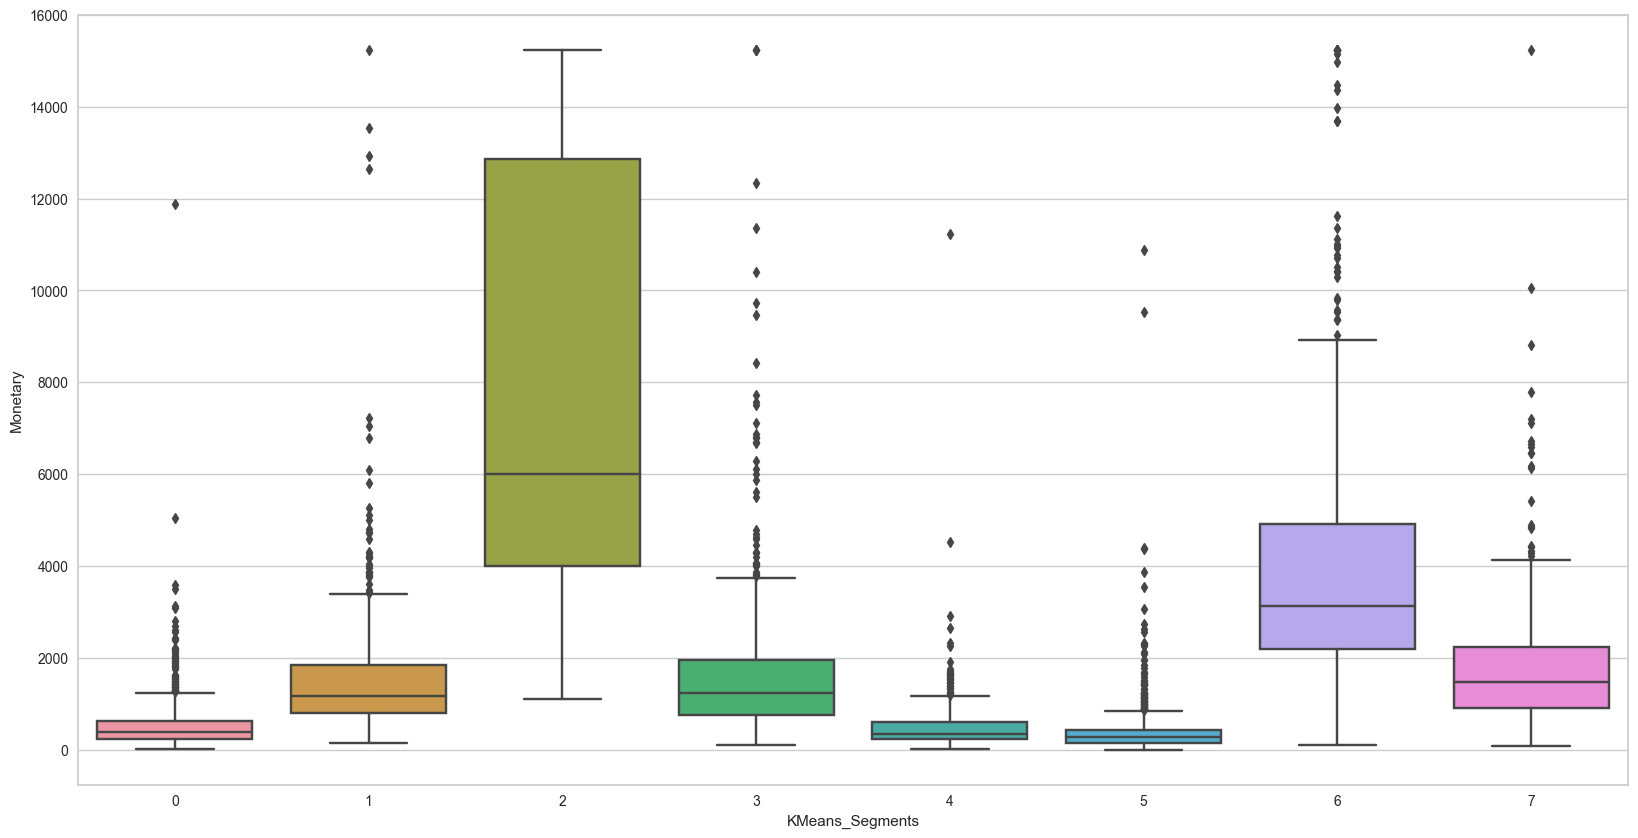

In [99]:
plt.figure(figsize=(20,10))
sns.boxplot(x = "KMeans_Segments", y = "Monetary", data=rfm)
plt.show();

In [100]:
# Hierarchical Clustering

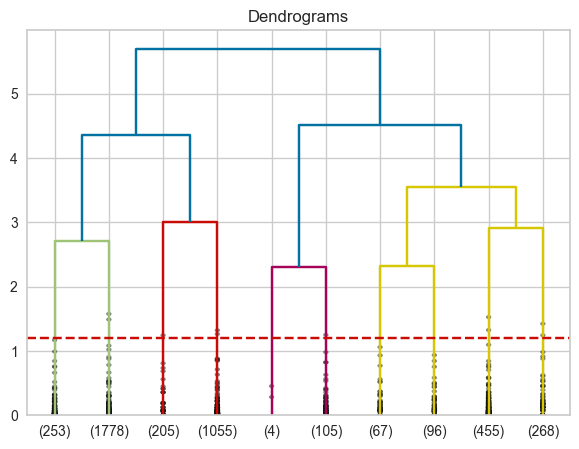

In [101]:
hc_complete = linkage (scaled_df,"complete")
plt.figure(figsize=(7,5))
plt.title("Dendrograms")
dend = dendrogram(hc_complete,
                 truncate_mode="lastp",
                 p = 10,
                 show_contracted=True,
                 leaf_font_size=10)
plt.axhline(y = 1.2, color = "r", linestyle = "--")
plt.show()

In [102]:
hc = AgglomerativeClustering(n_clusters=6)
segments = hc.fit_predict(scaled_df)
rfm["Hierarchi_Segments"] = segments
rfm.groupby("Hierarchi_Segments").agg({"Recency": ["mean", "median", "count"],
                                         "Frequency": ["mean", "median", "count"],
                                         "Monetary": ["mean", "median", "count"]})

Recency              Frequency              Monetary              
                      mean median count      mean median count     mean  median count
Hierarchi_Segments                                                                   
0                    22.54  17.00   915      8.22   7.00   915  3183.45 2342.57   915
1                    71.59  60.00  1091      3.42   3.00  1091  1354.29  940.86  1091
2                   227.53 220.00  1131      1.43   1.00  1131   474.46  301.65  1131
3                    13.24  13.00   462      2.05   2.00   462   654.60  498.73   462
4                    55.18  53.50   534      1.00   1.00   534   413.07  281.32   534
5                     5.11   5.00   153     21.38  19.00   153  8880.06 7637.56   153

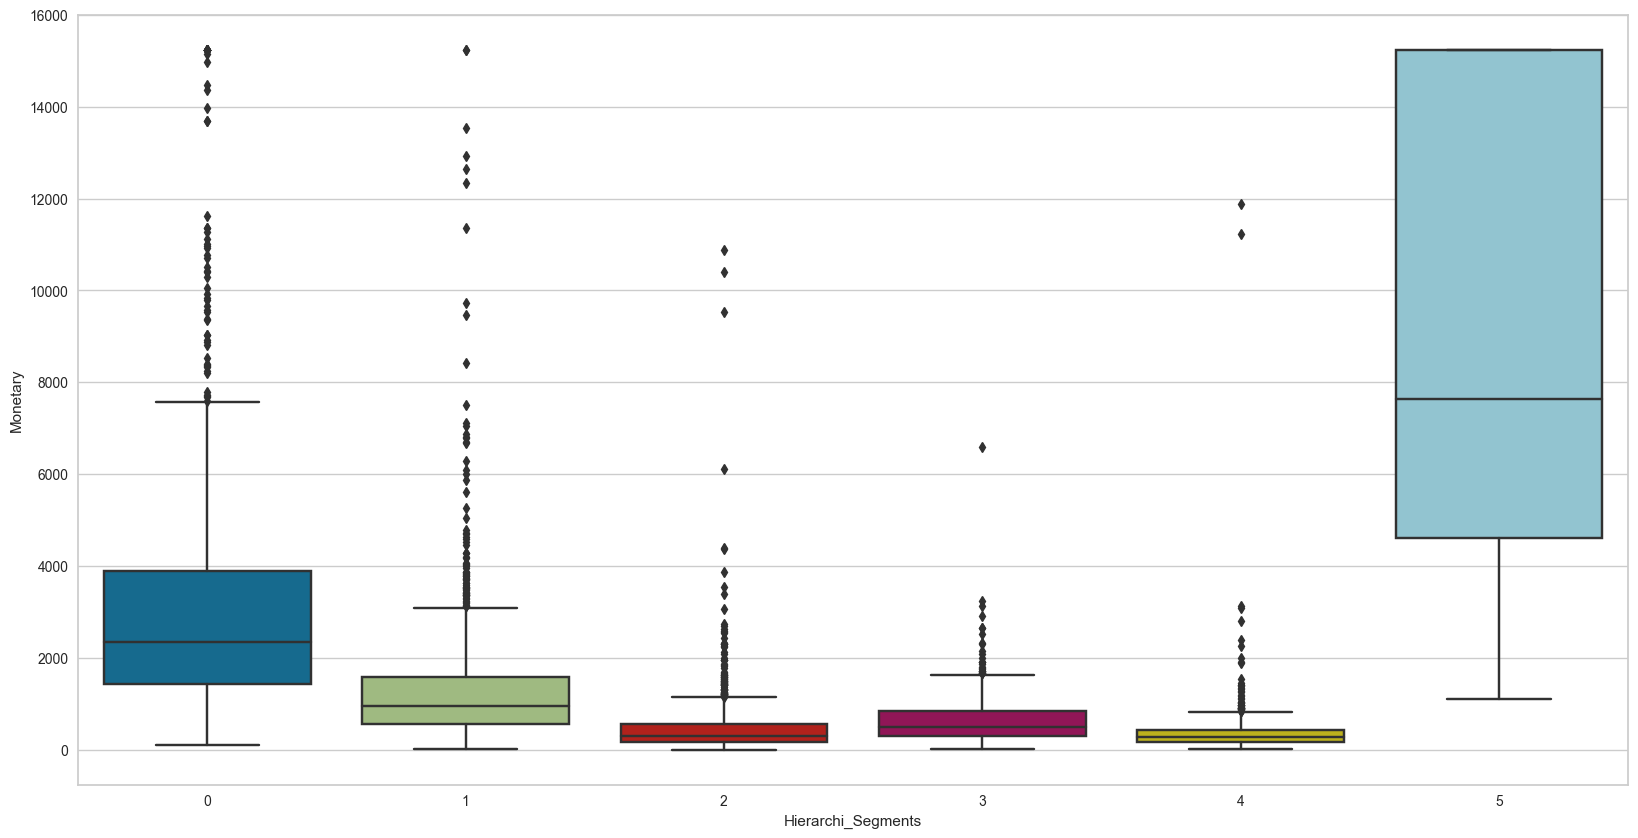

In [104]:
plt.figure(figsize = (20,10))
sns.boxplot(x= "Hierarchi_Segments", y="Monetary", data = rfm)
plt.show();